# A look into Airbnb services in Berlin

Airbnb has disrupted the traditional hospitality market, and is growing faster with more users each year. There is more and more data being collected every day, and thus there is a lot of potential to utilise the data to drive business insights and strategy.

In this notebook, we will be looking at Airbnb services in Berlin. We will explore the data, and generate insights from the data, as well as developing some machine learning tools that can help drive Airbnb's strategy.

We will examine the following datasets:

| Dataset | Description |
| :--- | :--- |
| listings.csv | Airbnb listings in Berlin, including descriptions of the property, price, review scores etc. |
| calendar.csv | For each listing, contains the days that it is available and its price |
| reviews.csv | For each listing, contains name, date and reviews from guests |
| Berlin Bus Stops.csv | List of bus stops in Berlin, including the type of spot, and latitude, longitude |
| Berlin Restaurants.csv | List of restaurants in Berlin, including the type of cuisine, and latitude, longitude |
| Berlin Touristic Places.csv |List of tourist attractions in Berlin, including the type of attraction, website and their latitude, longitude |
| Berlin Train Stations.csv | List of train stations in Berlin, and their latitude, longitude |
| London 05 June 2019.csv | Airbnb listings in London |
| Paris 05 June 2019.csv | Airbnb listings in Paris |

The datasets 'listings.csv' and 'reviews.csv' are publicly available from kaggle in the link below:
https://www.kaggle.com/brittabettendorf/berlin-airbnb-data

***

This notebook will be divided into 3 parts:

1. **Understanding the Berlin Airbnb market**
    - a) Show the distribution of the hosts based on annual income from Airbnb in Berlin?
    - b) Explain pricing and impact of seasonality in the context of Airbnb Berlin?
    - c) Some Berlin listings seems anomalous, can you structurally find these anomalies?


2. **Developing a ranking / recommendation engine for the Berlin market**
    - Design a normalized listing ranking system which would allow users seeking Airbnb services (or
even Airbnb marketplace team) to get a comparative holistic view of the Berlin listings.


3. **Comparison of Airbnb in different countries world wide**
    - a) In 2018, according to wikipedia [1, 2], London attracted 20M+ tourists, whereas there were 18M in Paris. What can you say about London and Paris from the Airbnb dataset?
    - b) Inferential Statistics: According to expatistan [3], London is 20% more expensive than France. What do you think from the Airbnb dataset (Careful with the assumptions, make sure to validate assumptions before performing hypothesis testing).
    - c) Optional: Any other comparative study you want to perform?

## 1. Understanding the Berlin Airbnb market
#### Problem 1: Rapid Data Visualisation and Prototyping
The first step to any data science problem is to understand the dataset on hand. With this in mind, we will explore the Berlin Airbnb datasets

**(a) Show the distribution of the hosts based on annual income from Airbnb in Berlin?**

***

Before analysing the data, it is important to clearly define the problem, as this will direct the analysis.

Firstly, it is important to note that hosts only earn income when they make their property available. This means that whilst a host might charge more for their property per night, they may decide to only rent out their property a few months a year. This means that even though these hosts earn more per night, their total annual income may be lower due to being a host fewer days in the year. If we don't carefully consider these 2 separately (that is, the price per night compared to the availability of the property), we will not be able to distinguish what is the driver for the distribution of hosts based on annual income.

Thus, this analysis will be broken down into 3 components:
1. What is the distribution of hosts based on the average price that their property is rented out?
2. What is the distribution of hosts based on the number of days that their property is rented out per night?
3. What is the distribution of hosts based on the total income earned in the last year?

By doing this, we can see the distribution of total income, as well as the drivers of this distribution based on average price and availability.

First, let us import the libraries that we will need to perform data analysis.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import display

We can then read in the files that contains the information regarding annual income for the hosts.

In [2]:
# Assign common path for all the files
file_path = '/Users/jeffreylee/Documents/'

# Assign path for each csv file
file_listings = file_path + 'Berlin_Airbnb_Dataset/listings.csv'
file_calendar = file_path + 'Berlin_Airbnb_Dataset/calendar.csv'
file_reviews = file_path + 'Berlin_Airbnb_Dataset/reviews.csv'

# Read in all the files into panda dataframes
df_listings = pd.read_csv(file_listings)
df_calendar = pd.read_csv(file_calendar)
df_reviews = pd.read_csv(file_reviews)

Within calendar.csv, we can see for each host id:
- whether the property was rented out
- what income was earned for that day

Let us look at a few rows of this dataset to better see what it contains.

In [3]:
display(df_calendar.iloc[125:,].head(5)) # show from row 125, since first few rows all have NaN for price

,listing_id,date,available,price
125,2015,2019-05-08,f,NaN
126,2015,2019-05-07,f,NaN
127,2015,2019-05-06,f,NaN
128,2015,2019-05-05,t,$76.00
129,2015,2019-05-04,t,$76.00


This shows that when the property is not available (f), the price is NaN. When the price is available (t), the price was $76 for 2019 May 4th and 5th.

As an additional check, we should see if the property is ever available with no price (which would indicate that the property was not rented out).

In [4]:
df_calendar[(df_calendar['available'] == 't') & (df_calendar['price'].isnull())]

,listing_id,date,available,price


Since there are no rows, we can conclude that a price is only shown when a property is available AND also there is a guest. If the property is available but not used by a guest, we are unable to identify this. This means that a limitation of this is that we are unable to determine the number of days that a host was unable to rent out their place when they wanted to.

Let us now look at for each host:
- What is the total revenue earned over the year?
- How many days were their property available?
- Average daily price?

In [5]:
# convert price currency to float
df_calendar['price'] = df_calendar['price'].replace('[\$,]', '', regex=True).astype(float)

# Function: Sum number of columns where value == 't'
def sum_t(df_col):
    return np.sum(df_col=='t')

# Group by id, and determine total income, and number of days the property was rented out
df_group_income = df_calendar.groupby(
    ['listing_id'] # group by listing_id
).agg(
    {
        'price':[sum], # sum of all income earned
        'available':[sum_t], # number of days property was rented out
        'date':['count'] # total number of days, regardless of whether it was rented out
    }
)

# Add a column that is the average daily income (for days where property is available)
df_group_income['avg_daily'] = df_group_income['price']['sum']/df_group_income['available']['sum_t']

# Add a column that is the average utilisation rate of each host's property
df_group_income['utilisation_rate'] = df_group_income['available']['sum_t']/df_group_income['date']['count']

df_group_income.columns = df_group_income.columns.droplevel(1) # Drop the agg level
df_group_income = df_group_income[df_group_income['available'] != 0] # remove hosts that did list their property in the last year

# Display first 10 rows
display(df_group_income.head(10))

,price,available,date,avg_daily,utilisation_rate
listing_id,,,,,
2015,11548.0,141,365,81.900709,0.386301
3176,19800.0,220,365,90.000000,0.602740
3309,8058.0,297,365,27.131313,0.813699
7071,1154.0,26,365,44.384615,0.071233
9991,24660.0,137,365,180.000000,0.375342
14325,9030.0,129,365,70.000000,0.353425
16401,43800.0,365,365,120.000000,1.000000
16644,14310.0,159,365,90.000000,0.435616
17409,1858.0,42,365,44.238095,0.115068


To assist with visualisation in Tableau, let us join the zipcode to each host from listings.csv.

In [6]:
# join the zipcode from listings.csv onto our dataframe
df_annual_income_analysis = pd.merge(df_group_income, df_listings[['id','zipcode','country']],
                                     how='left', left_on='listing_id', right_on='id')

display(df_annual_income_analysis.head(10))

,price,available,date,avg_daily,utilisation_rate,id,zipcode,country
0,11548.0,141,365,81.900709,0.386301,2015,10119,Germany
1,19800.0,220,365,90.000000,0.602740,3176,10405,Germany
2,8058.0,297,365,27.131313,0.813699,3309,10777,Germany
3,1154.0,26,365,44.384615,0.071233,7071,10437,Germany
4,24660.0,137,365,180.000000,0.375342,9991,10405,Germany
5,9030.0,129,365,70.000000,0.353425,14325,10437,Germany
6,43800.0,365,365,120.000000,1.000000,16401,10245,Germany
7,14310.0,159,365,90.000000,0.435616,16644,10997,Germany
8,1858.0,42,365,44.238095,0.115068,17409,10405,Germany
9,11368.0,232,365,49.000000,0.635616,17904,12047,Germany


In [7]:
# write to csv
df_annual_income_analysis.to_csv('/Users/jeffreylee/Documents/file1.csv',
                                 index = None, header=True)

Figure 1.1 below shows the distribution of annual income in 5k increments. The most common annual earning is less than 5k, with the number of hosts dropping quickly as the total annual income increases. There are very few users who earn over 100k in the last year, but this is the outlier rather than the norm.

This suggests that for majority of hosts in Berlin, airbnb is likely a source of side income, as it is insufficient to cover annual expenses (estimated to be $1,357 per month based on surveys).

<img src="images/1-1 Histogram of Annual Income.PNG">

Figure 1.2 and 1.3 show the distribution of the average daily prices of Berlin airbnb, and the average utilisation rate over the last year respectively. These plots will give us more insights into what drives the annual income distribution.

<img src="images/1-2 Histogram of Daily Prices.PNG">

This histogram for daily prices is very similar to annual income, also decreasing rapidly with the bulk of daily prices between just 20-60 dollars.

<img src="images/1-3 Histogram of Utilisation Rate.png">

The plot of utilisation rate shows an interesting finding. Most listings wither have a low utilisation rate near 0%, or an utilisation rate close to 100%. This suggests hosts either start airbnb but do not continue, or they become heavily invested into their airbnb business.

***
We can also examine how these 3 features are distributed spatially.

In figure 1.4, we have a map showing the distribution of annual income.

<img src="images/1-4 Map - Annual Income.png">

Around the edges, there are a few regions with very high annual income, however besides these few (potentially outliers), it appears as though regions around the center and to the left of Berlin are more expensive.

However there is no clear trend. We note again that this does not show us whether the annual income is driven by daily prices of utilisation rate, so let us again split by these two features.

<img src="images/1-5 Map - Daily Prices.png">

In figure 1.5, we plot daily prices based on region. There is a very obvious trend here now. Those regions around the center of Berlin are the most expensive, and as we move further out from the center the prices fall. This is expected, and was something that could be observed in the annual income map. Based off this, we suspect that the utilisation rate for cities out side center of Berlin should be higher.

<img src="images/1-6 Map - Utilisation Rate.png">

In figure 1.6, we have the average utilisation rate by region. We can see that our hypothesis was correct. Regions further from Berlin center have higher utilisation rate. This could perhaps be due to more competition in Berlin center, or that Berlin center is not as common a tourist accommodation site. Further analysis could help use to narrow down the root cause.

***

**(b) Explain pricing and impact of seasonality in the context of Airbnb Berlin?**

In a), we considered annual income, and also considered utilisation rate as well as average daily prices to understand the drivers of annual income. An additional analysis is to look at how the average daily prices and utilisation vary by season.

***

First, let us add the month and year to our data set from before.

In [8]:
df_calendar['year'] = df_calendar['date'].str.slice(0, 4) # Extract the year
df_calendar['month'] = df_calendar['date'].str.slice(5, 7) # Extract the month

We then group our dataset by listing id, year and the month.

In [9]:
# Group by id, and determine total income, and number of days the property was rented out
df_price_seasonal = df_calendar.groupby(
    ['listing_id','year','month'] # group by listing_id
).agg(
    {
        'price':['mean'], # sum of all income earned
        'available':[sum_t], # number of days property was rented out
        'date':['count'] # total number of days, regardless of whether it was rented out
    }
)

Again, we add the average utilisation rate (this time by month), and filter out hosts that did not have any listings in the year.

In [10]:
# Add a column that is the average utilisation rate of each host's property
df_price_seasonal['utilisation_rate'] = df_price_seasonal['available']['sum_t']/df_price_seasonal['date']['count']

df_price_seasonal.columns = df_price_seasonal.columns.droplevel(1) # Drop the agg level

# filter out listings where the property was not utilised in the last year
df_price_seasonal = df_price_seasonal.groupby('listing_id').filter(lambda x: x['available'].sum()!=0 )

# Display first 13 rows
display(df_price_seasonal.head(13))

price  available  date  utilisation_rate
listing_id year month                                               
2015       2018 11            NaN          0    24          0.000000
                12     111.000000         16    31          0.516129
           2019 01      83.225806         31    31          1.000000
                02      76.250000         28    28          1.000000
                03      76.032258         31    31          1.000000
                04      77.266667         30    30          1.000000
                05      76.400000          5    31          0.161290
                06            NaN          0    30          0.000000
                07            NaN          0    31          0.000000
                08            NaN          0    31          0.000000
                09            NaN          0    30          0.000000
                10            NaN          0    31          0.000000
                11            NaN          0     6          0.000000

In [11]:
# write to csv
df_price_seasonal = df_price_seasonal.reset_index() # reset index before exporting
df_price_seasonal.to_csv('/Users/jeffreylee/Documents/file2.csv',
                                 index = None, header=True)

<img src="images/1-7 Avg Price and Utilisation over time.png">

Figure 1.7 shows how the utilisation rate as well as average listed price varies over the year. Note that the final data point in 2019 November only has 6 days, so there will be more volatility in that month's value. Excluding that data point, we can see that the average prices is relatively consistent over the year. However, for utilisation rate, there is clearly a spike around New Years / Christmas in January.

***

**(c) Some Berlin listings seems anomalous, can you structurally find these anomalies?**

We define anomalous in the context of Berlin listings, as a listing that gives reasons for guests to suspect that the listing is not genuine. This can due to reasons such as:

- Duplicate listings: indicates hosts spamming the listings
- Duplicate reviews for the same host
- Unsafe conditions, not as described, fake photo etc. leading to bad experience

We will check each of these systematically to identify potentially anomalous listings.

***

**Duplicate listings**


We will check to see if there are any listings with:
- identical name
- identical summary
- identical description

In [12]:
#### Check how many listings have the same names
df_listings_group_name = df_listings.groupby(
    ['name'] # group by name
).agg(
    {
        'id':['count'], # count duplicate names
    }
)

df_listings_group_name = df_listings_group_name[df_listings_group_name['id']['count'] > 1] # filter only to the duplicated names
print("There are ",df_listings_group_name.shape[0]," different names that occur multiple times")

# create a list of names that may be anomalies
name_anomaly = df_listings_group_name.index.tolist()

display(df_listings_group_name.head(5))


There are  435  different names that occur multiple times


,id
,count
name,
110 SQM & 3 BEDROOM - DESIGN APARTMENT by BENSIMON,2
2 Zimmer Wohnung in Friedrichshain,2
2 Zimmer Wohnung mit Balkon,2
2 room apartment,2
2-Zimmer Design-Penthouse auf der Insel Eiswerder,5


In [13]:
#### Check how many listings have the same summary
df_listings_group_summary = df_listings.groupby(
    ['summary'] # group by name
).agg(
    {
        'id':['count'], # count duplicate names
    }
)

df_listings_group_summary = df_listings_group_summary[df_listings_group_summary['id']['count'] > 1] # filter only to the duplicated summaries
print("There are ",df_listings_group_summary.shape[0]," different summaries that occur multiple times")

# create a list of summaries that may be anomalies
summary_anomaly = df_listings_group_summary.index.tolist()

display(df_listings_group_summary.head(5))

There are  348  different summaries that occur multiple times


,id
,count
summary,
"'RATED EXCELLENT' tripadvisor 'WINNER, Top Vacation Rental, Berlin' (Hidden by Airbnb) 'One of the most popular holiday apartments of the region' (Hidden by Airbnb) BEST LOCATION (city center near Checkpoint Charlie, most famous sights can be reached by foot), MOST BEAUTIFUL HOUSE OF THE AREA (downtown city landmark of most legendary street, Friedrichstrasse), TOP CONDITION (total restoration 2014), QUIET (no drive through, because pedestrian zone starts 200 meters away).",2
"+ Rooftop and Terrace (privat) + Mauerpark nearby + Mauer Museum, Bernauer Str. (free entry) + Berlin wall Open Air Museum (free entry) + Shopping & Galeries in Mitte (10 Min. to walk)",2
"- Berlin - Prenzlauer Berg / Pankow - 3min walking to tram M12, M13 and M1, - 15min walking to S-Bahn Schönhauser (U2, S-Bahn/Ringbahn, tram M1), - close to Mauerpark, Stargarder Strasse, Hemholtzplatz, - walking to cafés, ice cream shops, playgrounds, restaurants, groceries etc, - 5th floor with terrace and light view onto TV tower at Alexanderplatz, - modern furniture, mostly white, - kids toys and books available, - 3 rooms, 100qm - whereas 1 or 2 bedrooms can be used and living room.",2
"--- Minimum stay 3 months --- Live in ""Stalin's Living Room"" equipped with modern design furniture!",3
"-english- Bright spacious room in shared flat (still clean and neat) with a nice view over the trees of Arnswalder Platz and the Fernsehturm (tv tower at Alexanderplatz)! Central location (2 km from Alexanderplatz), but in a quite area. -deutsch- Helles, großes Zimmer in WG (trotzdem sauber und ordentlich) mit Blick auf die Baumkronen des Arnswalder Platz und den Fernsehturm! Trotz der zentralen Lage (2 km vom Alexanderplatz), eine ruhige Gegend.",2


In [14]:
#### Check how many listings have the same description
df_listings_group_description = df_listings.groupby(
    ['description'] # group by description
).agg(
    {
        'id':['count'], # count duplicate names
    }
)

df_listings_group_description = df_listings_group_description[df_listings_group_description['id']['count'] > 1] # filter only to the duplicated descriptions
print("There are ",df_listings_group_description.shape[0]," different descriptions that occur multiple times")

# create a list of descriptions that may be anomalies
description_anomaly = df_listings_group_description.index.tolist()

display(df_listings_group_description.head(5))

There are  232  different descriptions that occur multiple times


,id
,count
description,
"'RATED EXCELLENT' tripadvisor 'WINNER, Top Vacation Rental, Berlin' (Hidden by Airbnb) 'One of the most popular holiday apartments of the region' (Hidden by Airbnb) BEST LOCATION (city center near Checkpoint Charlie, most famous sights can be reached by foot), MOST BEAUTIFUL HOUSE OF THE AREA (downtown city landmark of most legendary street, Friedrichstrasse), TOP CONDITION (total restoration 2014), QUIET (no drive through, because pedestrian zone starts 200 meters away). The apartment is for maximum of 6 adults. 2 children can stay in addition. MAGICIANS, THE GREENS, BANKERS AND FILMMAKERS This is the national heritage monument of one of the best-known areas of Berlin, Kreuzberg, also known as X-Berg, in one of Berlins most famous streets. Gutschow House, built in 1895, an important work of historicism (Neo-Gothic and Neo-Renaissance), is due to the elaborate façade design, its location, its history and the fact that is the only house in the area that 100% survived the World War II,",2
"+ Rooftop and Terrace (privat) + Mauerpark nearby + Mauer Museum, Bernauer Str. (free entry) + Berlin wall Open Air Museum (free entry) + Shopping & Galeries in Mitte (10 Min. to walk) Dachterrasse mit Blick auf den Park, und trotzdem mitten drin. Mitten in Berlin. Einzigartig. Ganz ruhig! Zu allen Teilen, inkl. Fahrstuhl. Ja. Sehr gerne. Prenzlauer Berg ist der wunderschöne Stadtteil, der die g Die Menschen, die Prenzlauer Berg prägten, sind vor allem Künstler. Aber auch speziell um den Helmholzplatz und Kollwitzstraße wimmelt es von Mütter mit ihren Kindern. Es handelt sich um den kinderfreundlichsten Stadtteil Berlins. 2 Trams direkt vor der Haustür. Die Ringbahn 42/41 sind nur 7 Min. Fussweg entfernt.",2
"--- Minimum stay 3 months --- Live in ""Stalin's Living Room"" equipped with modern design furniture! The design apartment is located in the district of Friedrichshain, in the impressive buildings of the former ""Stalin Avenue"". The street and the houses were built during the 1950s as a monumental socialist boulevard for East Berlin. Today it's the longest monument of the German Capital and is considered to be one of the most exciting spots of the city for architecture enthusiasts. Enjoy the modern and comfortable atmosphere in this urban design apartment which was completely refurbished beginning of 2013 offering everything you need for a great stay in Berlin. The apartment has a size of 60 sqm with two separate rooms and a central hall, kitchen and dining area. The kitchen is fully equipped with coffee and espresso machine, kettle, toaster, dishwasher, washing machine, fridge, induction hob, microwave / grill / oven, dishes, pots and all important cooking utensils. The bathroom is desig",2
.,7
...,3


Finally, we will filter all the listings that had either a duplicate name, summary or description.
These are listings that are potentially suspicious, but it most certainly does not indicate that they are fake listings. A manual look at these should be sampled to identify if they appear to be legitimate anomalies.

In [15]:
df_anomaly_list = df_listings[df_listings['name'].isin(name_anomaly) |
                              df_listings['summary'].isin(summary_anomaly) |
                              df_listings['description'].isin(description_anomaly)]

**Duplicate reviews**

We will check whether for any one listing, there are reviews with the same description.

In [16]:
df_reviews_group = df_reviews.groupby(
    ['listing_id','comments'] # group by listing_id and comments
).agg(
    {
        'id':['count'], # count duplicate ids
    }
)

df_reviews_group = df_reviews_group[df_reviews_group['id']['count'] > 1] # filter only to the duplicated comments

df_reviews_group.head(10) # display 10 rows

,,id
,,count
listing_id,comments,
57049,The host canceled this reservation 54 days before arrival. This is an automated posting.,2
83183,The reservation was canceled the day before arrival. This is an automated posting.,2
102882,The reservation was canceled 84 days before arrival. This is an automated posting.,2
188565,The host canceled this reservation 2 days before arrival. This is an automated posting.,2
237038,nice stay,4
316462,.,3
325979,The host canceled this reservation 26 days before arrival. This is an automated posting.,2
344856,Excellent Host and excellent accomodation!,2


Interestingly, we note that many of these are automated postings. These are also indications of suspicious listings, however for now we will filter out these comments, as they are not the intended purpose of this check for duplicated comments.

In [17]:
df_reviews_group_rm = df_reviews_group.reset_index() 
df_reviews_group_rm.columns = df_reviews_group_rm.columns.droplevel(1) # remove multi level indexing
df_reviews_group_rm = df_reviews_group_rm[~df_reviews_group_rm['comments'].str.contains('automated posting')] # remove automated posts

display(df_reviews_group_rm.sort_values(by=['id'], ascending=False).head(5)) # sort by largest first

,listing_id,comments,id
4,237038,nice stay,4
183,20752815,.,3
106,9707618,Great place!,3
169,19409050,"Eva and Barry were amazing hosts - helpful, we...",3
5,316462,.,3


Finally, let us also identify those with automated positings of late cancellations. Given that sometimes a host must cancel due to extenuating circumstances, we will count the number of cancellations and sort by number of cancellations.

In [18]:
# identify those that are automated postings
df_reviews_automated_posting = df_reviews[df_reviews['comments'].str.contains('automated posting', na=False)]

# identify those that were cancelled by the host
df_reviews_automated_posting = df_reviews_automated_posting[
    df_reviews_automated_posting['comments'].str.contains('host canceled', na=False)]

df_reviews_automated_posting = df_reviews_automated_posting.groupby(
    ['listing_id'] # group by listing_id and comments
).agg(
    {
        'id':['count'], # count duplicate ids
    }
)

df_reviews_automated_posting.columns = df_reviews_automated_posting.columns.droplevel(1) # remove multi level indexing
display(df_reviews_automated_posting.sort_values(by=['id'], ascending=False).head(5))

,id
listing_id,
863683,24
23739103,22
11142226,18
3579402,16
803960,15


We can see that there is a host with 24 cancellations! This is suspicious, and the hosts with many cancellations should be investigated for anomalies.

**Other**

There are so many other things that can be examined for anomalies. These will not be investigated in this notebook, however these checks can most certainly be automated. These include:

- Look at listings with low ratings
- Look at listings with high host response time and low response rate and acceptance rate
- Look at host verification status

These can all be given a weighting (as well as the duplicate analysis from above) to give a final score for likelihood for a listing to be an anomaly.

## 2. Developing a ranking / recommendation engine for the Berlin market
#### Problem 2: Rank the Berlin listings

Design a normalized listing ranking system which would allow users seeking Airbnb services (or
even Airbnb marketplace team) to get a comparative holistic view of the Berlin listings.

***

A ranking system should give a score to each listing, which would then allow the system to rank it. There are 2 steps in this process:
1. Determine what metrics should be used to score a listing
2. What weighting to assign each metric

Before detailing these two steps, it is important to first understand what the ranking system will be for. For example, if we wanted to identify the best property based on characterestics of the property itself, we would not want to use review scores to determine this. Instead, we would focus on characteristics that are would actually drive the review scores to be higher in the first place. (A similar analogy would be how you wouldn't use the rating to predict the rating itself!).

However, in this problem we are not trying to build a model to understand the true value of a listing. Users of Airbnb services care about certain things, and most certainly historical ratings plays a big part of this. For such a competitive market place, a bad review has a major impact on whether users will want to live there. Therefore, we should incorporate reviews in the ranking, so that users will see listings they are likely to want.

With this in mind, let us consider some metrics to use.
We will first explore the datasets.



In [19]:
# Assign path for each csv file
file_restaurant = file_path + 'Secondary_Berlin_Geospatial_Dataset/Berlin_Restaurants.csv'
file_tourist = file_path + 'Secondary_Berlin_Geospatial_Dataset/Berlin_Touristic_Places.csv'
file_bus = file_path + 'Secondary_Berlin_Geospatial_Dataset/Berlin_Bus_Stops.csv'
file_train = file_path + 'Secondary_Berlin_Geospatial_Dataset/Berlin_Train_Stations.csv'

# Read in all the files into panda dataframes
# Note the requirement to use tab delimited, as well as saving first as utf-8
df_restaurant = pd.read_csv(file_restaurant, sep='\t', encoding = 'utf-8')
df_tourist = pd.read_csv(file_tourist, sep='\t', encoding = 'utf-8')
df_bus = pd.read_csv(file_bus, sep='\t', encoding = 'utf-8')
df_train = pd.read_csv(file_train, sep='\t', encoding = 'utf-8')

In [20]:
# examine first 5 rows of each table
display(df_listings.head(5))
display(df_restaurant.head(5))
display(df_tourist.head(5))
display(df_bus.head(5))
display(df_train.head(5))

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76
1,2695,https://www.airbnb.com/rooms/2695,20181107122246,2018-11-07,Prenzlauer Berg close to Mauerpark,NaN,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,none,NaN,...,t,NaN,NaN,f,f,flexible,f,f,1,1.42
2,3176,https://www.airbnb.com/rooms/3176,20181107122246,2018-11-07,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,none,The neighbourhood is famous for its variety of...,...,t,NaN,NaN,t,f,strict_14_with_grace_period,f,f,1,1.25
3,3309,https://www.airbnb.com/rooms/3309,20181107122246,2018-11-07,BerlinSpot Schöneberg near KaDeWe,First of all: I prefer short-notice bookings. ...,"Your room is really big and has 26 sqm, is ver...",First of all: I prefer short-notice bookings. ...,none,"My flat is in the middle of West-Berlin, direc...",...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.39
4,7071,https://www.airbnb.com/rooms/7071,20181107122246,2018-11-07,BrightRoom with sunny greenview!,Cozy and large room in the beautiful district ...,"The BrightRoom is an approx. 20 sqm (215ft²), ...",Cozy and large room in the beautiful district ...,none,"Great neighborhood with plenty of Cafés, Baker...",...,t,NaN,NaN,f,f,moderate,f,f,1,1.75


,Cuisine,Name,Website,Geometry,Latitude (generated),Longitude (generated)
0,german,Zwanziger,https://www.freizeitoase.com,POINT,51.759574,14.340868
1,german,Zur Wiesenperle,http://www.zur-wiesenperle.de/,POINT,53.661656,13.898559
2,german,Zur Wassermühle Krosigk,https://www.wassermuehle-krosigk.de/,POINT,51.613862,11.938210
3,regional,Zur Walnuss,http://www.zurwalnuss.de/,POINT,53.169470,13.566054
4,german,Zur Waldschänke,http://www.waldschaenkerahmersee.de/,POINT,52.744702,13.412469


,Name,Tourism,Website,Geometry,Latitude (generated),Longitude (generated)
0,Zwischen Himmel und Erde,artwork,http://www.iba-see.de/grafik/sonstige/lena_sch...,MULTIPOINT,51.647269,14.108613
1,Ziehbrunnen,attraction,http://www.mittlere-elbe-flaeming.de/leaderneu...,POINT,51.948614,12.517015
2,Ziegeleipark Mildenberg,museum,https://www.ziegeleipark.de/,POINT,53.030774,13.309726
3,ZHP Świdnica w Niesulicach,camp_site,http://www.obozy-niesulice.pl,POINT,52.218530,15.382375
4,Zespół Szkół Technicznych,artwork,http://www.gazetalubuska.pl/wiadomosci/a/nowy-...,POINT,51.943978,15.513821


,Bus,Name,Public Transport,Geometry,Latitude (generated),Longitude (generated)
0,yes,"Zwochau, Leipziger Straße",stop_position,POINT,51.462949,12.269918
1,yes,"Zwochau, Am Teich",stop_position,POINT,51.466561,12.268636
2,yes,"Zwintschöna, Kabelsketal",stop_position,POINT,51.447403,12.047127
3,yes,Zwickauer Straße,stop_position,POINT,51.486176,12.043538
4,yes,"Zwenkau, Spenglerallee",stop_position,MULTIPOINT,51.206623,12.333179


,Id,Name,Geometry,Latitude (generated),Longitude (generated)
0,node/5718064630,U Kienberg (Gärten der Welt),POINT,52.529470,13.591077
1,node/5234611317,S+U Brandenburger Tor,POINT,52.516577,13.382239
2,node/5204006831,U Holzhauser Straße,POINT,52.576319,13.295377
3,node/5204006830,U Holzhauser Straße,POINT,52.576394,13.295547
4,node/5200360962,U Friedrich-Wilhelm-Platz,POINT,52.471417,13.329435


Based on a quick scan of the datasets, we can consider the following metrics:

*Host attributes*
- host_response_time
- host_response_rate
- host_acceptance_rate
- host_since (favour new)

*Property attributes*
- price - compared to average based on room_type and bedrooms
- distance to closest train
- distance to closest bus
- distance to restaurants
- distance to tourist attractions

*User reviews*
- number_of_reviews
- review_scores_rating

Note that for all these metrics, we need to ensure they are normalised on a comparable scale.

**Metric group 1: Host attributes**

These groups of attributes give as an idea of how reliable a host is. Response time, response rate and acceptance rate are likely to be extremely similar, and it may not not be necessary to have them all. *host_since* has been included, not because it necessarily means a listing is better, however we do want to give higher weighting to very recent hosts. We need to make sure hosts that just join airbnb will keep being part of the airbnb community, and this means making sure people see their listings, and therefore they can get more visits, reviews etc.

Let's examine these in more detail.

First we will check to see how many missings there are.

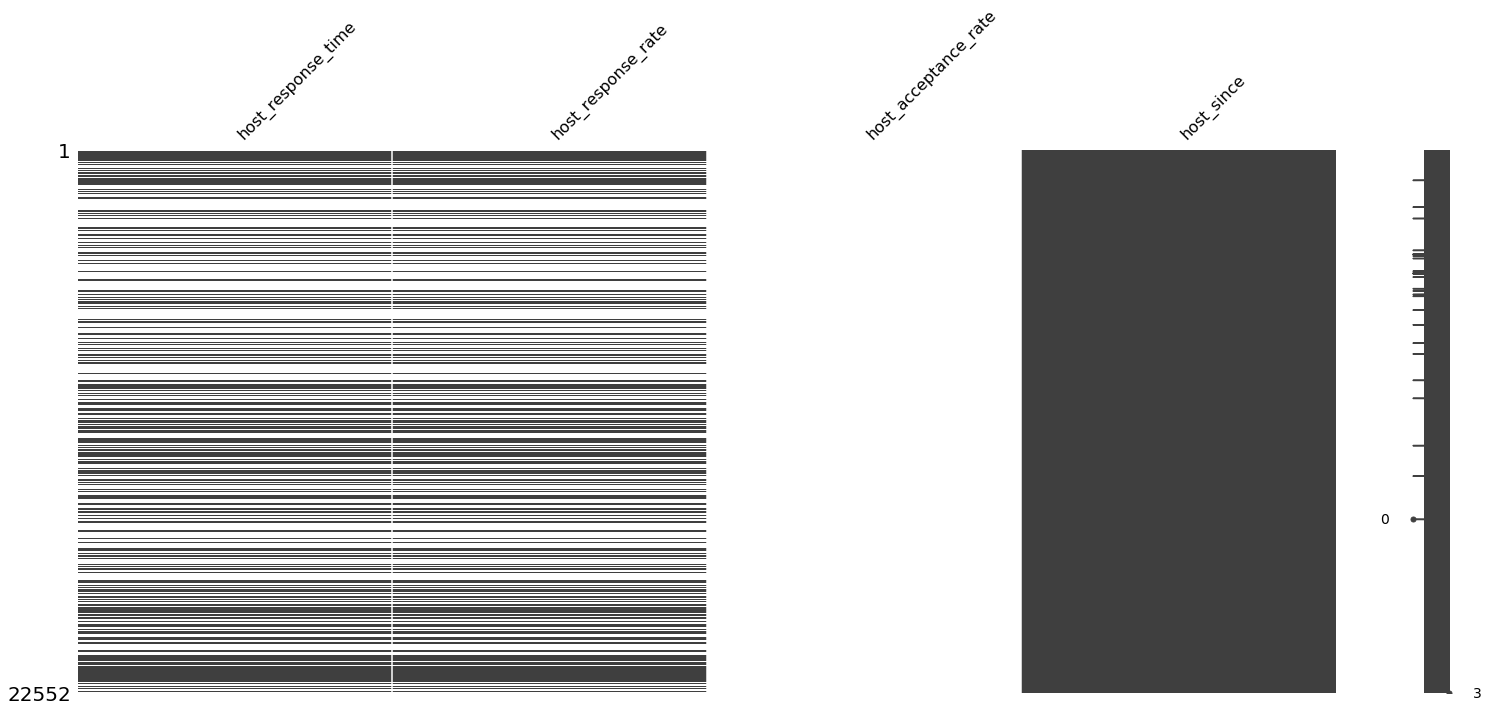

In [21]:
import missingno as msno

# fields we are interested in
field_interest = ['host_response_time','host_response_rate','host_acceptance_rate','host_since']

# This shows which fields have missing, and where they are missing. This is good for identifying where missing values are, 
# and whether there is correlation between the missings
msno.matrix(df_listings[field_interest]);

The plot above shows that host_acceptance_rate is always missing! This means we can not use this field as a metric.

*host_response_time* and *host_response_rate* have many missings, however they do not seem to be systematic reasons for the missing based on the ordering of the listings (since there are no chunks of missing).

Let's look at another plot that better shows how many are missing for each metric.

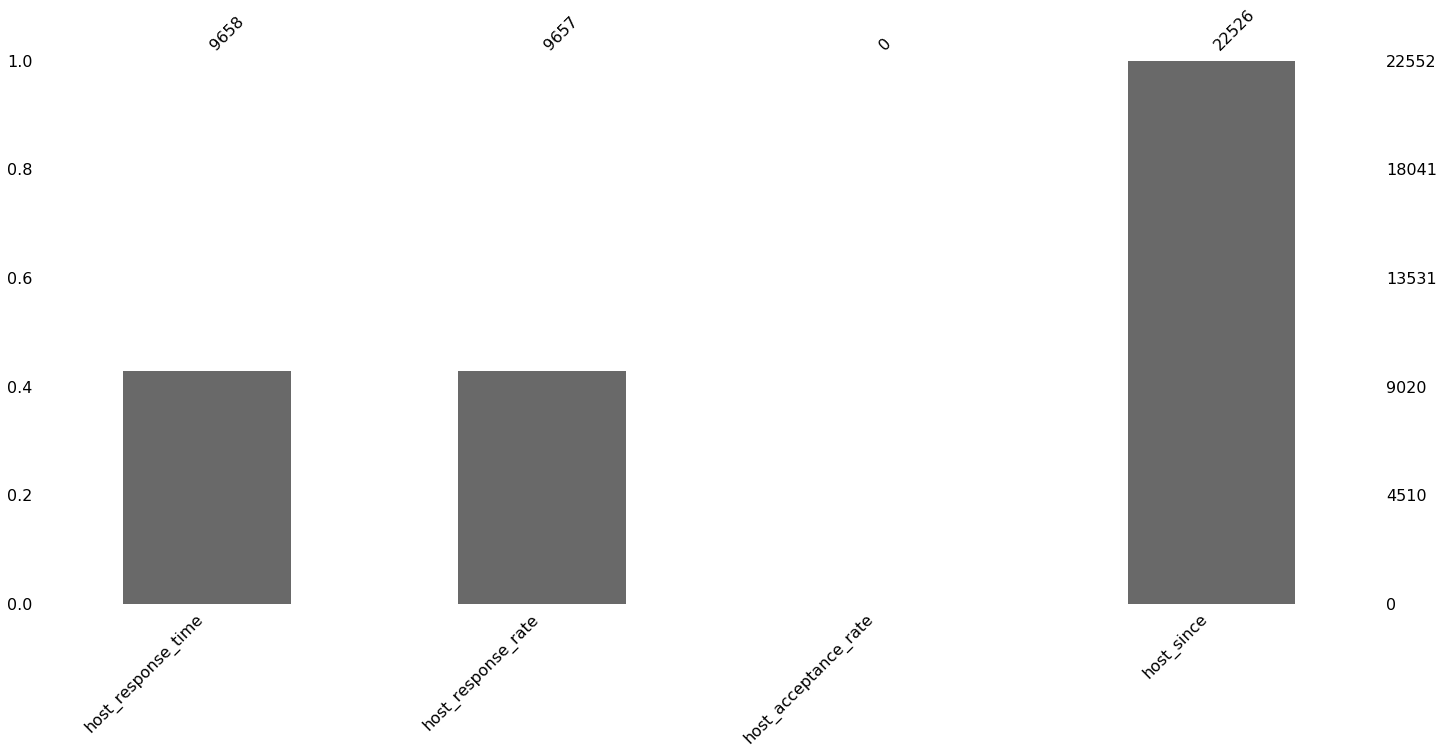

In [22]:
# This is a clearer plot of how many values are missing for each field (although doesn't show correlation)
msno.bar(df_listings[field_interest]);

In the plot above, we cans now clearly see that *host_response_time* and *host_response_rate* have nearly 60% missing. This is too large to be useful for modelling (typically 30% is too much).

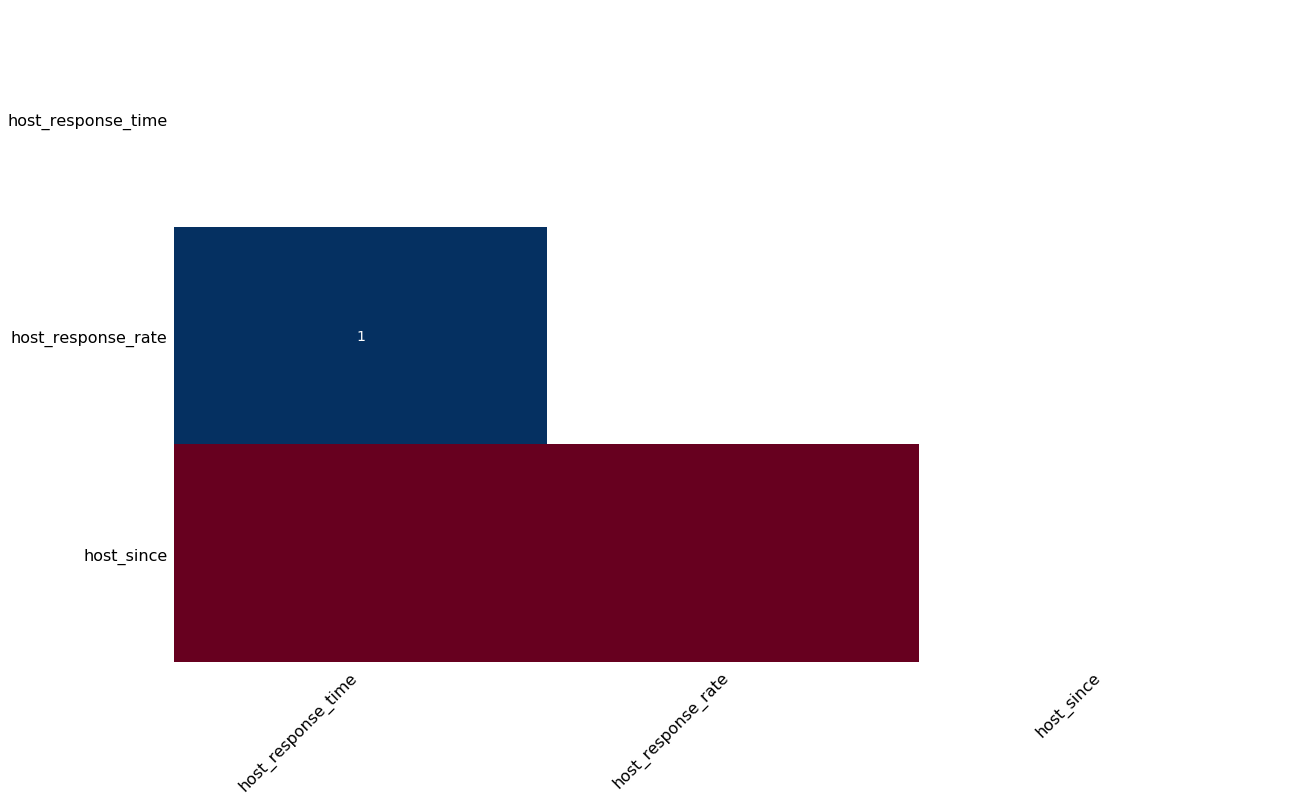

In [23]:
# This a direct plot of the correlation between missing fields
try:
    msno.heatmap(df_listings[field_interest]) 
except ValueError:  #raised if there are no missings
    pass

Finally, the correlation plot above of missing values confirms that *host_response_rate* and *host_response_time* is highly correlated (with respect to when a missing occurs).

As a result, only *host_since* will be used. We should create a binary flag; 1 for a host in the last 3 months, and 0 otherwise. This will give a new host 3 months to get good reviews from greater exposure.

In [24]:
df_ranking = df_listings.copy(deep=True)

In [25]:
from datetime import timedelta

# replace missing with '1900-01-01'
df_ranking['host_since'].fillna('1900-01-01', inplace=True)

# convert string to date object
df_ranking['host_since_flag'] = pd.to_datetime(df_ranking['host_since'])

# Assign 1 for hosts originated in the last 90 days
conditions = [
    (df_ranking['host_since_flag'] >= (df_ranking['host_since_flag'].max() - timedelta(days=90))),
    (df_ranking['host_since_flag'] < (df_ranking['host_since_flag'].max() - timedelta(days=90)))]
choices = [1, 0]
df_ranking['host_since_flag'] = np.select(conditions, choices, default=0)

Our metric host_since is now scaled between 0 and 1 by definition, since it is a flag.

**Metric group 2: Property attributes**

We consider the following attributes:
- price - compared to average based on room_type and bedrooms
- distance to closest train
- distance to closest bus
- distance to restaurants
- distance to tourist attractions

***
***Price***

For the price, it is important to realise that price alone is not a useful indicatory. If a single room cost $150, that will be really expensive in Berlin, however for a 5 bedroom, that is a bargain! To get a useful comparison, we need to consider pricing along with the type of room (whole apartment, private room etc.) and how many bedrooms. Thus, we will determine the average price for listings based on the room type and number of bedrooms, and compare this to each individual listing to assess if it is a good deal (and therefore of interest to users).

We will now compare each listing price to the average *price* based on *room_type* and *bedrooms*.

In [63]:
keep = ['room_type', 'bedrooms', 'price', 'id'] # just keep the columns we need

# convert price currency to float
df_ranking.loc[:,'price'] = df_ranking['price'].replace('[\$,]', '', regex=True).astype(float)

# clean bedroom column
df_ranking.loc[(df_ranking['bedrooms'].isna()) | 
           (df_ranking['bedrooms']=='1900-01-01'), 'bedrooms'] = 0 # replace missing bedrooms and random date with 0
df_ranking_subset = df_ranking[keep]

df_ranking_subset.loc[df_ranking_subset['bedrooms'] > 5, 'bedrooms'] = 5.0 # group bedrooms > 5 together

# convert price currency to float
df_ranking_subset['price'] = df_ranking_subset['price'].replace('[\$,]', '', regex=True).astype(float)

df_ranking_subset_g = df_ranking_subset.groupby(
    ['room_type', 'bedrooms'] # group by room_type and bedrooms
).agg(
    {
        'price':['mean'], # mean price
        'id':['count'] # count number of listings
    }
)
df_ranking_subset_g.columns = df_ranking_subset_g.columns.droplevel(1) # drop multi-level
df_ranking_subset_g = df_ranking_subset_g.reset_index()

display(df_ranking_subset_g)

/Users/jeffreylee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,room_type,bedrooms,price,id
0,Entire home/apt,0.0,61.472489,1145
1,Entire home/apt,1.0,68.567643,6076
2,Entire home/apt,2.0,96.841547,2638
3,Entire home/apt,3.0,150.483824,680
4,Entire home/apt,4.0,180.738806,134
5,Entire home/apt,5.0,503.020408,49
6,Private room,0.0,37.865714,350
7,Private room,1.0,52.121108,10792
8,Private room,2.0,68.701493,335
9,Private room,3.0,97.279070,43


We will then join this back onto the main table.

In [27]:
# rename columns
df_ranking_subset_g.rename(index=str,
                       columns={"price": "avg_price_by_room_bed_group",
                                "id": "listing_count_by_room_bed_group"
                               },
                      inplace=True);

df_ranking_g2 = pd.merge(df_ranking, df_ranking_subset_g,
                                     how='left', on=['room_type','bedrooms'])

In [28]:
display(df_ranking_g2.head(3))

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_since_flag,avg_price_by_room_bed_group,listing_count_by_room_bed_group
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,...,f,f,strict_14_with_grace_period,f,f,4,3.76,0,68.567643,6076.0
1,2695,https://www.airbnb.com/rooms/2695,20181107122246,2018-11-07,Prenzlauer Berg close to Mauerpark,NaN,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,none,NaN,...,f,f,flexible,f,f,1,1.42,0,52.121108,10792.0
2,3176,https://www.airbnb.com/rooms/3176,20181107122246,2018-11-07,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,none,The neighbourhood is famous for its variety of...,...,t,f,strict_14_with_grace_period,f,f,1,1.25,0,68.567643,6076.0


We need to scale/normalise this result in order for it to have any meaning.

In order to make the listing price have a meaningful comparison with each other (based on room type and bedrooms), we will calculate the deviation from the *avg_price_by_room_bed_group* for each listing (based on high many multiples of the average it is).

In [29]:
df_ranking_g2['price_value'] = df_ranking_g2['price']/df_ranking_g2['avg_price_by_room_bed_group']

Let us plot a histogram of these values to see the distribution of *price_value*, as there may be some extreme values that skew the distribution.

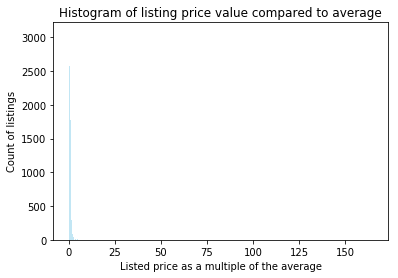

In [30]:
# Plot histogram of price_value
binwidth = 0.1
plt.hist(df_ranking_g2['price_value'],
         color='skyblue',
         lw=1,
         alpha=0.5,
         bins=np.arange(min(df_ranking_g2['price_value']),
                   max(df_ranking_g2['price_value']) + binwidth, binwidth))
plt.title('Histogram of listing price value compared to average')
plt.xlabel('Listed price as a multiple of the average')
plt.ylabel('Count of listings');

The outliers make it difficult to see the overall distribution. Let us restrict it to maximum of 5 (i.e. listed price being 5 times higher than average)

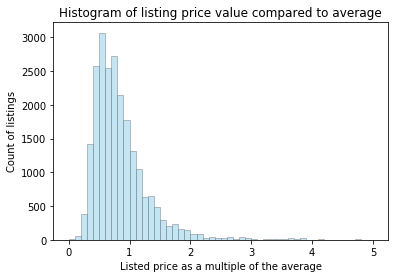

In [31]:
# Plot histogram of price_value
binwidth = 0.1
plt.hist(df_ranking_g2['price_value'],
         color='skyblue',
         lw=1,
         ec='gray',
         alpha=0.5,
         bins=np.arange(min(df_ranking_g2['price_value']),
                   5 + binwidth, binwidth))
plt.title('Histogram of listing price value compared to average')
plt.xlabel('Listed price as a multiple of the average')
plt.ylabel('Count of listings');

We now have a clearer picture. Most listings do not exceed a multiple of 3. To make sure the scale is not too right skewed, let us group all the multiples greater than 3 together.

In [32]:
# cap value at 3
df_ranking_g2.loc[df_ranking_g2['price_value']>3,'price_value'] = 3

Finally, we will scale this metric to be between 0 and 1.

In [33]:
# Scale metric to between 0 and 1
df_ranking_g2['price_value_scaled'] = df_ranking_g2['price_value']/df_ranking_g2['price_value'].max()

***
***Distance***

For travelling, tourists want an airbnb that is close to tourist attractions, good cuisine and convenient for transport.

For this reason, we will look for each listing, and within a 5km radius:
- How many tourist attractions there are
- How many restaurants nearby
- How many bus stops
- How many train stations

First, let us define two functions that will allow us to calculate the distances (*haversine_np*), and subsequently determine how many are close by for each listing (*proximity_list*).

In [34]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Summary: Calculate the great circle distance between two points
    on the earth (specified in radians)

    Parameters:
    lon1 (np array of radians): Longitude of points 1
    lat1 (np array of radians): Latitude of points 1
    lon1 (np array of radians): Longitude of points 2
    lat1 (np array of radians): Latitude of points 2
    
    Returns:
    km: np array of distance between each point of points, in km
    """
    
    dlon = lon2 - lon1 # distance between longitudes
    dlat = lat2 - lat1 # distance between latitudes

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def proximity_list(df1, df_interest, radius):
    """
    Summary: Given two columns of coordinates, for each coordinate in column 1, it will
    determine how many coordinates in column 2 are within the radius of each point.
    
    Parameters:
    df1 (dataframe): must contain coordinates in a column called 'latitude' and 'longitude'
    df_interest (dataframe): must contain coordinates in a column called 
                             'Latitude (generated)' and 'Longitude (generated)'
    df_interest = list of coordinates for places of interest
    radius (float): indicates radius to search for in km
    
    Returns:
    proximity_list (array): array containing number of close places of interest for each
                            coordinate in column 1
    """
    # initialise array that will be the return array
    proximity_list = np.repeat(-1,df1.shape[0]) # set to -1, this will indicate something went wrong
                                                # if it is still present after function runs since
                                                # distance >= 0
    
    i = 0
    for index, row in df1.iterrows(): # loop through each coordinate in df1
        
        long = np.repeat(row['longitude'],df_interest.shape[0]) # repeat coordinates to perform vector operation
        lat = np.repeat(row['latitude'],df_interest.shape[0])
        
        # Calculate haversine distance between all sets of points against specified coordinate
        result = haversine_np(
            np.radians(long),
            np.radians(lat),
            np.radians(df_interest['Longitude (generated)'].astype('float')), # convert to float and radians
            np.radians(df_interest['Latitude (generated)'].astype('float'))
        )
        
        proximity_list[i] = result[result<radius].shape[0] # only count results that are within radius
        i = i + 1       
        
    return proximity_list

In [35]:
# Calculate the proximity to nearby places of interest for each listing
tourist_proximity = proximity_list(df_ranking_g2, df_tourist, 5)
restaurant_proximity = proximity_list(df_ranking_g2, df_restaurant, 5)
bus_proximity = proximity_list(df_ranking_g2, df_bus, 5)
train_proximity = proximity_list(df_ranking_g2, df_train, 5)

Let us plot the distributions on a histogram to better understand the spreads of tourist attractions, restaurants and transportation.

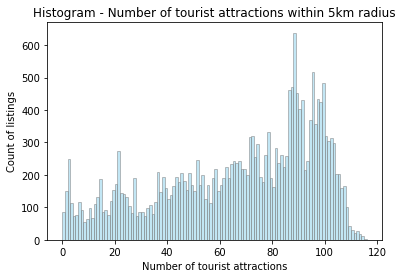

In [36]:
# Plot histogram of price_value
binwidth = 1
plt.hist(tourist_proximity,
         color='skyblue',
         lw=1,
         ec='gray',
         alpha=0.5,
         bins=np.arange(min(tourist_proximity),
                   max(tourist_proximity) + binwidth, binwidth))
plt.title('Histogram - Number of tourist attractions within 5km radius')
plt.xlabel('Number of tourist attractions')
plt.ylabel('Count of listings');

From the histogram above, the number of tourist attractions seem relatively well spread out, without any clear skew.

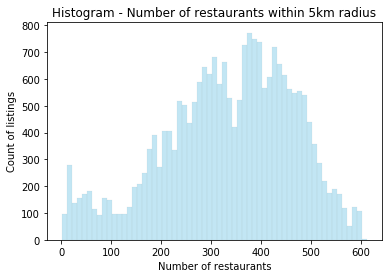

In [37]:
binwidth = 10
plt.hist(restaurant_proximity,
         color='skyblue',
         lw=0.1,
         ec='gray',
         alpha=0.5,
         bins=np.arange(min(restaurant_proximity),
                   max(restaurant_proximity) + binwidth, binwidth))
plt.title('Histogram - Number of restaurants within 5km radius')
plt.xlabel('Number of restaurants')
plt.ylabel('Count of listings');

The number of restaurants also seem relatively well spread out, without any clear skew.

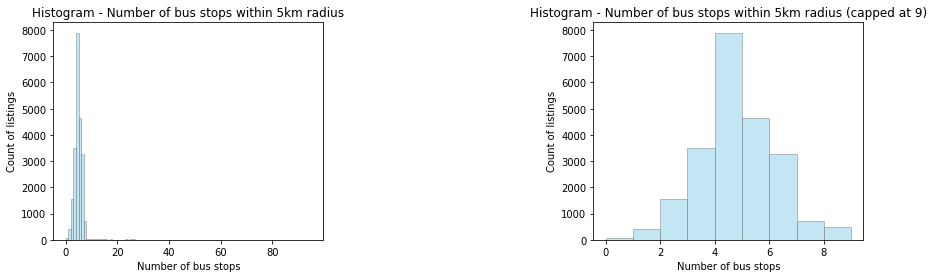

In [38]:
fig = plt.figure()
fig.subplots_adjust(hspace=1, wspace=1, right=2) # set parameters to adjust plot positioning
fig.add_subplot(1, 2, 1) # plot side by side

binwidth = 1
plt.hist(bus_proximity,
         color='skyblue',
         lw=1,
         ec='gray',
         alpha=0.5,
         bins=np.arange(min(bus_proximity),
                   max(bus_proximity) + binwidth, binwidth))
plt.title('Histogram - Number of bus stops within 5km radius')
plt.xlabel('Number of bus stops')
plt.ylabel('Count of listings');

fig.add_subplot(1, 2, 2)
bus_proximity_norm = bus_proximity
bus_proximity_norm[bus_proximity_norm>=9] = 9 # group together 9 or more bus stops

binwidth = 1
plt.hist(bus_proximity,
         color='skyblue',
         lw=1,
         ec='gray',
         alpha=0.5,
         bins=np.arange(min(bus_proximity),
                   max(bus_proximity) + binwidth, binwidth))
plt.title('Histogram - Number of bus stops within 5km radius (capped at 9)')
plt.xlabel('Number of bus stops')
plt.ylabel('Count of listings');

There is a sharp drop in the number of bus stops after 9. This suggests that we should group 9 or more bus stops together. (Having more than 9 more stops would have diminishing value so this makes sense). The plot on the right shows the effect after grouping, which has a much nicer distribution.

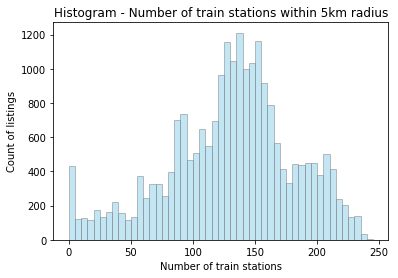

In [39]:
binwidth = 5
plt.hist(train_proximity,
         color='skyblue',
         lw=1,
         ec='gray',
         alpha=0.5,
         bins=np.arange(min(train_proximity),
                   max(train_proximity) + binwidth, binwidth))
plt.title('Histogram - Number of train stations within 5km radius')
plt.xlabel('Number of train stations')
plt.ylabel('Count of listings');

The distribution of the number of train stations also seem relatively consistent, and does not require further adjustments.

Finally, now that we are happy with the distributions of these distance metrics, we need to scale them between 0 and 1 so that they can be compared.

In [40]:
# Scale each of the distance metrics
tourist_proximity_scaled = tourist_proximity/tourist_proximity.max()
restaurant_proximity_scaled = restaurant_proximity/restaurant_proximity.max()
bus_proximity_scaled = bus_proximity/bus_proximity.max()
train_proximity_scaled = train_proximity/train_proximity.max()

# Add scaled distance metrics to main data
df_ranking_g2['tourist_proximity_scaled'] = tourist_proximity_scaled
df_ranking_g2['restaurant_proximity_scaled'] = restaurant_proximity_scaled
df_ranking_g2['bus_proximity_scaled'] = bus_proximity_scaled
df_ranking_g2['train_proximity_scaled'] = train_proximity_scaled

**Metric group 3: User attributes**

The final metric is looking at how users have reviewed each listing. The two key criteria here are how many reviews, and what the reviews rated the listing as.

Naturally, the higher the review scores the better. However, we also want to look at the number of reviews. If there are many reviews, then the scores are more reliable. On the other hand, if there a few reviews, then the review score should be given less weighting.

*User reviews*
- number_of_reviews
- review_scores_rating

We will take into account these considerations the following way:
1. For missing review scores, fill in with the average
2. For each score, also determine % deviation from the average
3. If the number of reviews for that listing is < 5, then the score isn't very accurate. In this case, adjust the review score by reducing the % deviation from mean by 50% (this could either increase or decrease the score).

e.g. If average score is 90, and a listing has a score of 60 but only has 3 reviews. Since the number of reviews < 5, we will adjust the score. The % deviation is -33.3%. We will reduce the deviation by 50%, to -16.65%. The final score is then 75.015.




In [41]:
# 1. Fill missing review scores with the average
score_mean = df_ranking_g2['review_scores_rating'].mean()
df_ranking_g2['review_scores_rating'].fillna(score_mean, inplace=True)

# 2. Determine % deviation from the average
df_ranking_g2['review_scores_percent_deviation'] = (df_ranking_g2['review_scores_rating'] - score_mean) / score_mean

# 3. Adjust % deviation from average if < 5 reviews
df_ranking_g2.loc[df_ranking_g2['number_of_reviews'] < 5, 'review_scores_percent_deviation'] = df_ranking_g2['review_scores_percent_deviation']/2
# adjust review score
df_ranking_g2['review_scores_rating_adj'] = score_mean*(1+df_ranking_g2['review_scores_percent_deviation'])

We then scale this to 0-1 as with all the other metrics.

In [42]:
df_ranking_g2['review_scores_rating_adj'] = df_ranking_g2['review_scores_rating_adj']/df_ranking_g2['review_scores_rating_adj'].max()

Finally, we will clean up our dataframe to only contain the metrics we need.

In [43]:
keep = [
    # id and name are not metrics, but property identifiers
    'id',
    'name',
    
    # the below are metrics
    'host_since_flag',
    'price_value_scaled',
    'tourist_proximity_scaled',
    'restaurant_proximity_scaled',
    'bus_proximity_scaled',
    'train_proximity_scaled',
    'review_scores_rating_adj'
]

df_metric = df_ranking_g2[keep]

In [44]:
display(df_metric.head(10))

,id,name,host_since_flag,price_value_scaled,tourist_proximity_scaled,restaurant_proximity_scaled,bus_proximity_scaled,train_proximity_scaled,review_scores_rating_adj
0,2015,Berlin-Mitte Value! Quiet courtyard/very central,0,0.291683,0.844828,0.707438,0.444444,0.657025,0.930000
1,2695,Prenzlauer Berg close to Mauerpark,0,0.108721,0.672414,0.537190,0.444444,0.623967,1.000000
2,3176,Fabulous Flat in great Location,0,0.437524,0.827586,0.667769,0.444444,0.623967,0.920000
3,3309,BerlinSpot Schöneberg near KaDeWe,0,0.166279,0.896552,0.842975,0.555556,0.876033,0.880000
4,7071,BrightRoom with sunny greenview!,0,0.268605,0.750000,0.595041,0.444444,0.611570,0.960000
5,9991,Geourgeous flat - outstanding views,0,0.331971,0.827586,0.695868,0.444444,0.623967,1.000000
6,14325,Apartment in Prenzlauer Berg,0,0.379574,0.681034,0.538843,0.444444,0.636364,0.930000
7,16401,APARTMENT TO RENT,0,0.767443,0.620690,0.570248,0.555556,0.442149,0.944139
8,16644,In the Heart of Berlin - Kreuzberg,0,0.437524,0.724138,0.707438,0.555556,0.574380,0.940000
9,17409,Downtown Above The Roofs In Berlin,0,0.287791,0.853448,0.737190,0.333333,0.665289,0.960000


***

### Assigning weightings to the chosen metrics
Having chosen, normalised and scaled the metrics, the final step is to assign weights. Note that for all our metrics, they have been designed so that they are between 0 and 1, with a higher number indicating a better listing based on that metric. By taking a weighted sum of the metric, we can derive a score for each listing and thus rank the listings.

We note the following limitations in this ranking system:
- The weighting are subjective and will require ongoing tuning
- Some metrics are correlated, and interactions between metrics are not captured well

With this in mind, the following weightings were chosen. Note that only the relative difference between the weightings are important, not the absolute value.


| Metric | Weighting | Reason |
| :--- | :--- | |
| review_scores_rating_adj | 40 | Ultimately, historical reviews make the most difference as it is a direct indication of likely experience. |
| price_value_scaled | 40 | Price is always a main factor, so the value of the listing in terms of price gets a high weighting |
| tourist_proximity_scaled | 20 | People are likely interested places close to most tourist locations. Given this is the most common purpose of finding accomodation, it is the most important distance metric, hence the higher weighting than restaurant and transportation. |
| restaurant_proximity_scaled | 10 | Tourists are often interested in local cuisine, thus this is included. However, generally this is not the most important criteria for deciding airbnb. |
| bus_proximity_scaled | 5 | Transportation is given a low weighting as it may not be important. Many people drive in which case this is irrelevant. Furthermore, having both buses and trains may not be necessary as only one is required, thus the weighting for transport is split between bus and train equally at a low weighting of 5. |
| train_proximity_scaled | 5 | See above as per bus_proximity_scaled |
| host_since_flag | 2 | For new hosts we want to give them a higher rank for greater exposure. Whilst a weighting of 5 seems low, this is actually quite material because host_since_flag is either 0 or 1. Thus, those that are new hosts will get a 5 point boost in the score. (For example, even though review_scores_rating_adj has a weighting of 40, because most listings have similarly high rating, the difference is not necessarily higher). A weighting of 5 was tested, however this resulted in all the highest scoring listings to be new hosts. |

We will now assign a score for each listing based on the weightings and metrics above, and sort by the score.

In [45]:
# Assign score for each listing
df_metric_final = df_metric.copy(deep=True)

# Calculate score
df_metric_final.loc[:,'score'] = 40*df_metric['review_scores_rating_adj'] +\
    40*df_metric['price_value_scaled'] +\
    20*df_metric['tourist_proximity_scaled'] +\
    10*df_metric['restaurant_proximity_scaled'] +\
    5*df_metric['bus_proximity_scaled'] +\
    5*df_metric['train_proximity_scaled'] +\
    2*df_metric['host_since_flag']

# Add adjusted metrics by weight to final output to understand driver
df_metric_final['review_scores_rating_adj'] = 40*df_metric['review_scores_rating_adj']
df_metric_final['price_value_scaled'] = 40*df_metric['price_value_scaled']
df_metric_final['tourist_proximity_scaled'] = 20*df_metric['tourist_proximity_scaled']
df_metric_final['restaurant_proximity_scaled'] = 10*df_metric['restaurant_proximity_scaled']
df_metric_final['bus_proximity_scaled'] = 5*df_metric['bus_proximity_scaled']
df_metric_final['train_proximity_scaled'] = 5*df_metric['train_proximity_scaled']
df_metric_final['host_since_flag'] = 2*df_metric['host_since_flag']

# sort by score
df_metric_final = df_metric_final.sort_values(by=['score'], ascending=False)
display(df_metric_final.head(10))

,id,name,host_since_flag,price_value_scaled,tourist_proximity_scaled,restaurant_proximity_scaled,bus_proximity_scaled,train_proximity_scaled,review_scores_rating_adj,score
17600,23317727,Suite im Sony Center am Potsdamer Platz,0,40.0,18.620690,9.900826,3.333333,4.814050,40.000000,116.668899
17582,23302498,Charming Potsdamer Pl. Loft w/ industrial details,0,40.0,18.275862,9.834711,3.333333,4.731405,40.000000,116.175311
20622,27521072,"Luxurious private room in Sony Center, Mitte",0,40.0,18.793103,9.917355,3.333333,4.772727,38.882773,115.699292
21439,28533803,Unser Lieblingsplatz (fjord hotel berlin),2,40.0,18.103448,9.520661,3.333333,4.834711,37.765545,115.557699
21441,28534680,Unser Gemütliches (fjord hotel berlin),2,40.0,18.103448,9.487603,3.333333,4.834711,37.765545,115.524641
21443,28535860,Kleines Feines (fjord hotel berlin),2,40.0,18.103448,9.504132,3.333333,4.793388,37.765545,115.499848
21442,28535346,Unser Feines (fjord hotel berlin),2,40.0,17.931034,9.520661,3.333333,4.855372,37.765545,115.405946
21440,28534517,Unser Badezimmer (fjord hotel berlin),2,40.0,17.931034,9.537190,3.333333,4.834711,37.765545,115.401814
20113,26807658,"Mitte, Designer trendy flat. Perfect location.",0,40.0,18.793103,9.785124,3.333333,4.173554,38.882773,114.967887
10076,15070161,Room is no longer available,0,40.0,18.620690,9.652893,3.333333,4.214876,38.882773,114.704564


Finally, we have all our listsings sorted by rank!

## 3. Comparison of Airbnb in different countries world wide
#### Problem 3: London, United Kingdom vs Paris, France

We will now compare Airbnb in London and Paris.

**a) In 2018, according to wikipedia [1, 2], London attracted 20M+ tourists, whereas there were 18M in Paris. What can you say about London and Paris from the Airbnb dataset?**

***


To explore tourism in London and Paris, we will first read in the respective airbnb listings for each city. 

In [46]:
low_memory=False

# Assign common path for all the files
file_path = '/Users/jeffreylee/Documents/'

# Assign path for each csv file
london_listing_path = file_path + 'Comparative_Market_Analysis_Dataset/London_05_June_2019.csv'
paris_listing_path = file_path + 'Comparative_Market_Analysis_Dataset/Paris_05_June_2019.csv'

# Read in all the files into panda dataframes
df_london = pd.read_csv(london_listing_path)
df_paris = pd.read_csv(paris_listing_path)

/Users/jeffreylee/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/jeffreylee/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


As always, let us look at the first few rows of the data.

In [47]:
display(df_london.head(3))
display(df_paris.head(3))

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20190605194943,2019-06-07,Arty and Bright London Apartment in Zone 2,This flat is located in the trendy neighbour o...,"Amenities Bedding: 1 Double bed, 1 living room...",This flat is located in the trendy neighbour o...,family,"Brixton, one of the oldest quarter of London, ...",...,f,f,strict_14_with_grace_period,f,t,2,2,0,0,1.63
1,13913,https://www.airbnb.com/rooms/13913,20190605194943,2019-06-07,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,...,f,f,moderate,f,f,3,1,2,0,0.14
2,15400,https://www.airbnb.com/rooms/15400,20190605194943,2019-06-07,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,romantic,It is Chelsea.,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.74


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3109,https://www.airbnb.com/rooms/3109,20190605195019,2019-06-06,zen and calm,Appartement très calme de 50M2 Utilisation de ...,I bedroom appartment in Paris 14,I bedroom appartment in Paris 14 Good restaura...,none,Good restaurants very close the Montparnasse S...,...,f,f,flexible,f,f,1,1,0,0,0.27
1,5396,https://www.airbnb.com/rooms/5396,20190605195019,2019-06-06,Explore the heart of old Paris,"Cozy, well-appointed and graciously designed s...","Small, well appointed studio apartment at the ...","Cozy, well-appointed and graciously designed s...",none,"You are within walking distance to the Louvre,...",...,t,f,strict_14_with_grace_period,f,f,1,1,0,0,1.44
2,7397,https://www.airbnb.com/rooms/7397,20190605195019,2019-06-06,MARAIS - 2ROOMS APT - 2/4 PEOPLE,"VERY CONVENIENT, WITH THE BEST LOCATION !",PLEASE ASK ME BEFORE TO MAKE A REQUEST !!! No ...,"VERY CONVENIENT, WITH THE BEST LOCATION ! PLEA...",none,NaN,...,f,f,moderate,f,f,1,1,0,0,2.47


Wikipedia's count of 20M+ and 18M+ is based off all tourists, however in our data, we have the following limitations:

- We only have data on airbnb hosts in each city
- Each host will house more than 1 tourist a year. Some hosts may only house a few tourists a years, others may host all year round. Thus, each listing should not be equally weighted in terms of tourist count

Thus, when we compare the tourists count in each city, we need to examine the utilisation rate in the last year of each host as well. This suggests using the field 'availability_365' to determine the number of days the property was available. We also need to take into account the number of people that each host can accomodate, so we will also look at the field 'accommodates'.

To summarise, for each listing, we will assume that in the last year, it accommodated:

**Number of tourists for each property = availability_365 x accommodates**

***

Many assumptions have been made here, including:
- It is assumed 'availability_365' is defined as the number of days in the last 365 days that the property was rented out. (This may not be true. For example it could be defined as the number of days the property available, but not necessarily if it was utilised. We assume the first definition due to lack of data dictionary, and it is consistent with the calendar.csv for Berlin, where only those rented out had prices)
- It is assumed that airbnb is representative of the distribution of tourists. This may not be true (perhaps people in Paris like to use airbnb more!)

Finally, before conducting the above calculations, there are some important things that must be checked, including:
- Check 1: Is the date scraped a snapshot in time? Or is it multiple days?
- Check 2: Are there duplicate listings in the data (particularly if scraped over multiple days?)


**Check 1: Is the date scraped a snapshot in time?**

In [48]:
print("London listings are scraped during the following days: ",df_london['last_scraped'].unique())
print("Paris listings are scraped during the following days: ",df_paris['last_scraped'].unique())

London listings are scraped during the following days:  ['2019-06-07' '2019-06-06' '2019-06-10']
Paris listings are scraped during the following days:  ['2019-06-06' '2019-06-07' '2019-06-05']


The listings are in fact scraped over 3 days. Furthermore, the days they are scraped are not aligned! This means the comparisons are not aligned. We would want to align the window, so we should likely remove 10th June from London, and 5th of June from Paris. However, first let us check if there are duplicate listings.

**Check 2: Are there duplicate listings in the data?**

First we need to define what a duplicate listing is. We will define duplicate listing as below:

*Duplicate listing is when the same host AND property appears more than once in the data set*

There is no data dictionary, so we will assume a few definitions (which will be tested):
1. host_id is unique identifier of each host
2. id is unique identifier for each property

First, let us check if a host_id can have more than one id.

In [49]:
df_london_group = df_london.groupby(
    ['host_id'] # group by host_id
).agg(
    {
        'id':['count'], # count duplicate ids
    }
)

df_london_group.sort_values([('id','count')], ascending=False).head(5)

,id
,count
host_id,
33889201,1127
156158778,270
28820321,204
137094377,178
48165024,164


Clearly, id is not unique. This is consistent with our assumption that a host can have many ids. However, we should check this is the case. The host_id 33889201 has 1127 id counts, which is suspicious.

In [50]:
df_london[df_london['host_id']==33889201].head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
9325,6682937,https://www.airbnb.com/rooms/6682937,20190605194943,2019-06-07,"Wonderful 1 BR in Fulham with river views, Veeve",Sleek 1 bed apartment boasting a modern open-p...,ENTRANCE Enter into a stunning mirrored entran...,Sleek 1 bed apartment boasting a modern open-p...,none,Step outside and take a stroll along the Thame...,...,f,f,strict_14_with_grace_period,f,f,1127,1124,3,0,0.20
9327,6683135,https://www.airbnb.com/rooms/6683135,20190605194943,2019-06-07,"Modern Thameside 2BR, Chelsea Bridge, by Veeve","This contemporary two bedroom apartment, benef...",The large open plan kitchen and living area ha...,"This contemporary two bedroom apartment, benef...",none,Chelsea Bridge Wharf is located just 0.75 mile...,...,t,f,strict_14_with_grace_period,f,f,1127,1124,3,0,0.07
9328,6683264,https://www.airbnb.com/rooms/6683264,20190605194943,2019-06-07,"Sleek 1 BR with panoramic views, Pimlico, by V...","Situated in London’s most popular region, righ...","The building sits on Grosvenor Road, right by ...","Situated in London’s most popular region, righ...",none,Just a few minutes walk from the apartment wil...,...,t,f,strict_14_with_grace_period,f,f,1127,1124,3,0,0.23
9336,6684343,https://www.airbnb.com/rooms/6684343,20190605194943,2019-06-07,"3 BR with private garden, Putney, by Veeve","Set back from the road, this property is decep...","From the front door you step into a large, tas...","Set back from the road, this property is decep...",none,Putney lies just south of the river and is ful...,...,t,f,strict_14_with_grace_period,f,f,1127,1124,3,0,0.20
12220,8206251,https://www.airbnb.com/rooms/8206251,20190605194943,2019-06-06,"Up to 20% off! Open-plan 2 bed, Islington","This home is wonderfully located, tucked away ...",The property has a lower ground floor entrance...,"This home is wonderfully located, tucked away ...",none,Islington is a perfect base to explore London ...,...,t,f,strict_14_with_grace_period,f,f,1127,1124,3,0,0.04


If these are legitimately from the same host, then some values we would expect to be the same. For example:
- host name
- host url
- host since
- host location
- host neighbourhood

We would also expect some values to be unique (or mostly unique), such as:
- name
- summary
- space
- description

Note: It is reasonable that some properties may have the same description. E.g. multiple properties in a large apartnment may have same description and space.

In [51]:
host_33889201 = df_london[df_london['host_id']==33889201] # filter to only this host

# columns that we would expect to be the same given the host is the same
same_host = ['host_name','host_url','host_since','host_location','host_neighbourhood']

# Check that for these columns, the number of unique values is 1
print("Expected number of values are 1 for each column.")
for col_check in same_host:
    print("There are ", host_33889201[col_check].unique().shape[0], " unique values for column ", col_check)

print("\n") # print new line

# columns that we would expect to be different for the same host
different_host = ['name','summary','space','description']

# Check that for these columns, the number of unique values is 1
print("Expected number of values are ", host_33889201.shape[0], " for each column.")
for col_check in different_host:
    print("There are ", host_33889201[col_check].unique().shape[0], " unique values for column ", col_check)

Expected number of values are 1 for each column.
There are  1  unique values for column  host_name
There are  1  unique values for column  host_url
There are  1  unique values for column  host_since
There are  1  unique values for column  host_location
There are  1  unique values for column  host_neighbourhood


Expected number of values are  1127  for each column.
There are  1126  unique values for column  name
There are  1118  unique values for column  summary
There are  1099  unique values for column  space
There are  1125  unique values for column  description


From this, it is reasonble to believe they are all from the same host, and mostly unique properties. Out of 1127, 1126 have unique property names. As mentioned, the duplicate summaries and spaces are likely due to property in the same building. We note in particular that even though for this host, it was scraped over multiple days, there are no duplicate names as a result of this. This suggests that despite scraping occuring over multiple days, the same property was not replicated 3 times.

Unfortunately without more information, we can not determine precisely how the scraping was performed (was duplicates removed each day it was scraped? Why would listings change so much day by day?).

There are a never ending list of things to check, however for the sake of brevity and practicality, we will suffice with this analysis.

We keep in mind that the method of determining number of tourist each property per year is already an approximation, and slight optimisations will not be the main determinant of the accuracy. A better way to optimise the result is to ensure data fields are appropriate (data dictionary), consider other data sources etc.

As a result of the data checks, we will then perform the following **data cleaning**:
1. Remove scraped data on 5th June for Paris
2. Remove scraped data on 10th June for London

In [52]:
df_london_clean = df_london[df_london['last_scraped']!='2019-06-10']
df_paris_clean = df_paris[df_paris['last_scraped']!='2019-06-05']

***

Finally, we apply the formula below to the cleaned data:

**Number of tourists for each property = availability_365 x accommodates**

In [53]:
london_tourist_count = (df_london_clean['availability_365']*df_london_clean['accommodates']).sum()
paris_tourist_count = (df_paris_clean['availability_365']*df_paris_clean['accommodates']).sum()

print("London tourist count is ", london_tourist_count)
print("Paris tourist count is ", paris_tourist_count)

London tourist count is  31114249
Paris tourist count is  16233544


Some important comments on the results:
- These results are very different from Wikipedia's page. Wikipedia's page is from 2018, whereas this data is from mid 2019, however that is unlikely to explain the extremely large change in tourist count.
- Perhaps people from Paris also do not use airbnb as much as London
- This suggests that there are key assumptions made that are not accurate. For example, *availability_365* may not be the number of days the property was used, but could just be number of days it was listed. Without a data dictionary there is no way to confirm this. **This is most likely the driver of the results.** 

Further analysis and verification of these assumptions are out of scope, however they are noted above as limitations in this analysis.

***
**(b) Inferential Statistics: According to expatistan [3], London is 20% more expensive than France. What do you think from the Airbnb dataset (Careful with the assumptions, make sure to validate assumptions before performing hypothesis testing).**

It is important to first define how we compare prices between the two cities. The initial hypothesis that London is 20% more expensive than Paris may have some truth, however this is based off:
- food
- housing
- clothes
- transportation
- personal care
- entertaiment

We do not have this information, and none one of these are the same as tourist accommodation, thus there is no relevant comparison here. The best we can do is compare tourist accommodation prices, and assume that it will be correlated to prices in the categories above.

Furthermore, it is only fair to compare the same kind of airbnb with each other. For example, it wouldn't make sense to compare a 3 bedroom price with that of a single room. If we simply look at average price per night without taking into account these considerations, we are making an implicit assumptions that the distribution of properties (in terms of their characteristics) are the same, which is unlikely to be true.

Before defining how we will compare prices, let use explore the key factors that may drive price of each property.

In [54]:
display(df_london.describe())

,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,jurisdiction_names,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,8.202900e+04,8.202900e+04,0.0,0.0,0.0,8.202900e+04,0.0,81993.000000,81993.000000,0.0,...,59299.000000,59358.000000,59298.000000,59300.000000,0.0,82029.000000,82029.000000,82029.000000,82029.000000,61089.000000
mean,2.064686e+07,2.019061e+13,NaN,NaN,NaN,7.602756e+07,NaN,30.790189,30.790189,NaN,...,9.639488,9.672462,9.516594,9.287201,NaN,24.730022,22.814870,1.849005,0.066147,1.157330
std,9.894110e+06,1.832042e+00,NaN,NaN,NaN,7.565680e+07,NaN,165.801379,165.801379,NaN,...,0.882092,0.867078,0.833796,1.021941,NaN,132.835467,132.536425,6.659177,0.900098,1.364338
min,1.155100e+04,2.019061e+13,NaN,NaN,NaN,2.010000e+03,NaN,0.000000,0.000000,NaN,...,2.000000,2.000000,2.000000,2.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.334453e+07,2.019061e+13,NaN,NaN,NaN,1.420204e+07,NaN,1.000000,1.000000,NaN,...,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.230000
50%,2.157666e+07,2.019061e+13,NaN,NaN,NaN,4.377861e+07,NaN,2.000000,2.000000,NaN,...,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.000000,1.000000,0.000000,0.700000
75%,2.920561e+07,2.019061e+13,NaN,NaN,NaN,1.293780e+08,NaN,5.000000,5.000000,NaN,...,10.000000,10.000000,10.000000,10.000000,NaN,4.000000,2.000000,1.000000,0.000000,1.550000
max,3.541913e+07,2.019061e+13,NaN,NaN,NaN,2.665544e+08,NaN,1369.000000,1369.000000,NaN,...,10.000000,10.000000,10.000000,10.000000,NaN,1127.000000,1124.000000,96.000000,23.000000,15.150000


In [55]:
display(df_paris.describe())

,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,6.082200e+04,6.082200e+04,0.0,0.0,0.0,6.082200e+04,0.0,60800.000000,60800.000000,0.0,...,46247.000000,46211.000000,46240.000000,46214.000000,46213.000000,60822.000000,60822.000000,60822.000000,60822.000000,47404.000000
mean,1.821092e+07,2.019061e+13,NaN,NaN,NaN,6.266774e+07,NaN,14.407385,14.407385,NaN,...,9.202608,9.682110,9.716220,9.646904,9.266635,8.350104,7.910115,0.417020,0.022969,1.143651
std,1.059039e+07,9.480547e+00,NaN,NaN,NaN,7.238030e+07,NaN,87.805977,87.805977,NaN,...,1.074361,0.737739,0.713421,0.690880,0.908696,36.483087,35.776587,1.985092,0.380267,1.411328
min,3.109000e+03,2.019061e+13,NaN,NaN,NaN,2.419000e+03,NaN,0.000000,0.000000,NaN,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,8.479792e+06,2.019061e+13,NaN,NaN,NaN,1.038048e+07,NaN,1.000000,1.000000,NaN,...,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.220000
50%,1.878964e+07,2.019061e+13,NaN,NaN,NaN,3.140784e+07,NaN,1.000000,1.000000,NaN,...,9.000000,10.000000,10.000000,10.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.650000
75%,2.723928e+07,2.019061e+13,NaN,NaN,NaN,8.508889e+07,NaN,2.000000,2.000000,NaN,...,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,0.000000,0.000000,1.530000
max,3.541837e+07,2.019061e+13,NaN,NaN,NaN,2.665580e+08,NaN,1412.000000,1412.000000,NaN,...,10.000000,10.000000,10.000000,10.000000,10.000000,302.000000,301.000000,32.000000,14.000000,54.000000


The factors that would likely have a big impact on the price of the night are:
- bedrooms
- accommodates
- beds
- room_type

However, the first 3 are likely to be extremely highly correlated. As bedrooms increase, so will the number of beds and how many people it accommodates. Let us check this with a correlation matrix.

Text(0.5, 0.98, 'Attribute Correlation Matrix')

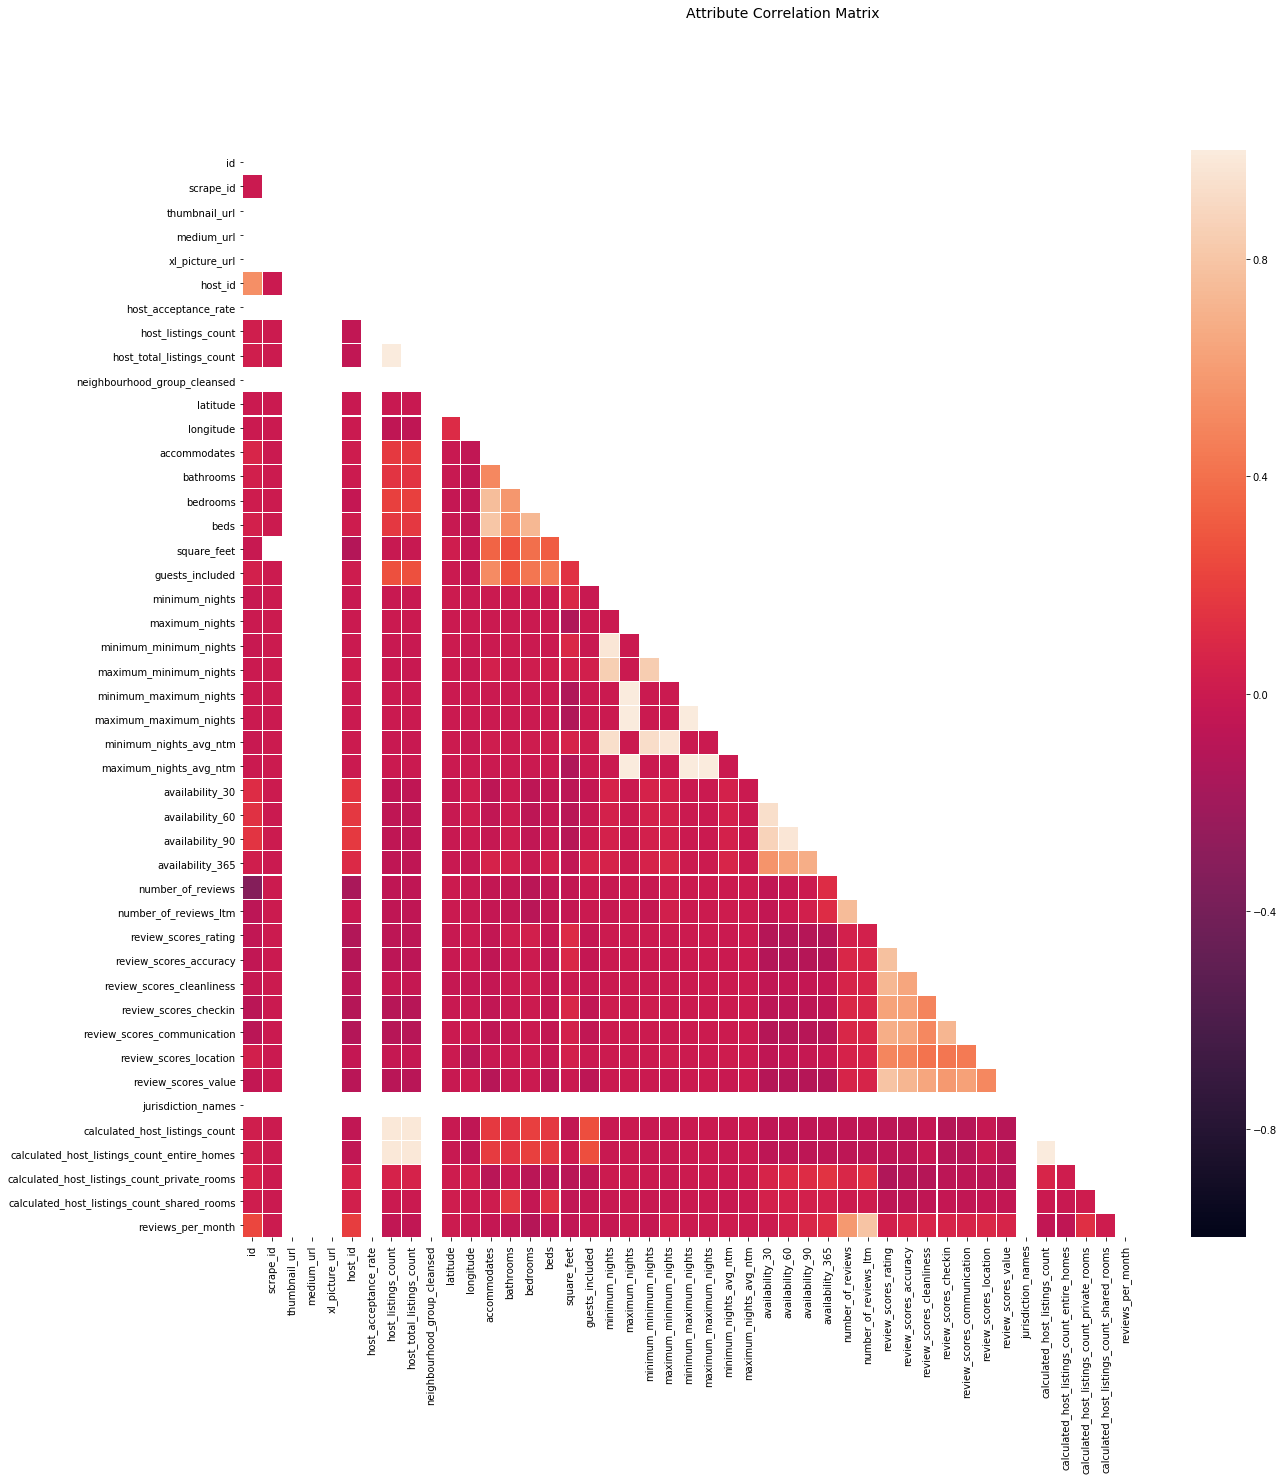

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# calculate correlation
corr = df_london.corr()

# plot correlation matrix
fig = plt.figure(figsize=(20, 20))
mask = np.zeros_like(corr, dtype=np.bool) # create mask to cover the upper triangle
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(corr, annot=False, mask=mask, vmin=-1, vmax=1,linewidths=0.1)
fig.suptitle('Attribute Correlation Matrix', fontsize=14)

Text(0.5, 0.98, 'Attribute Correlation Matrix')

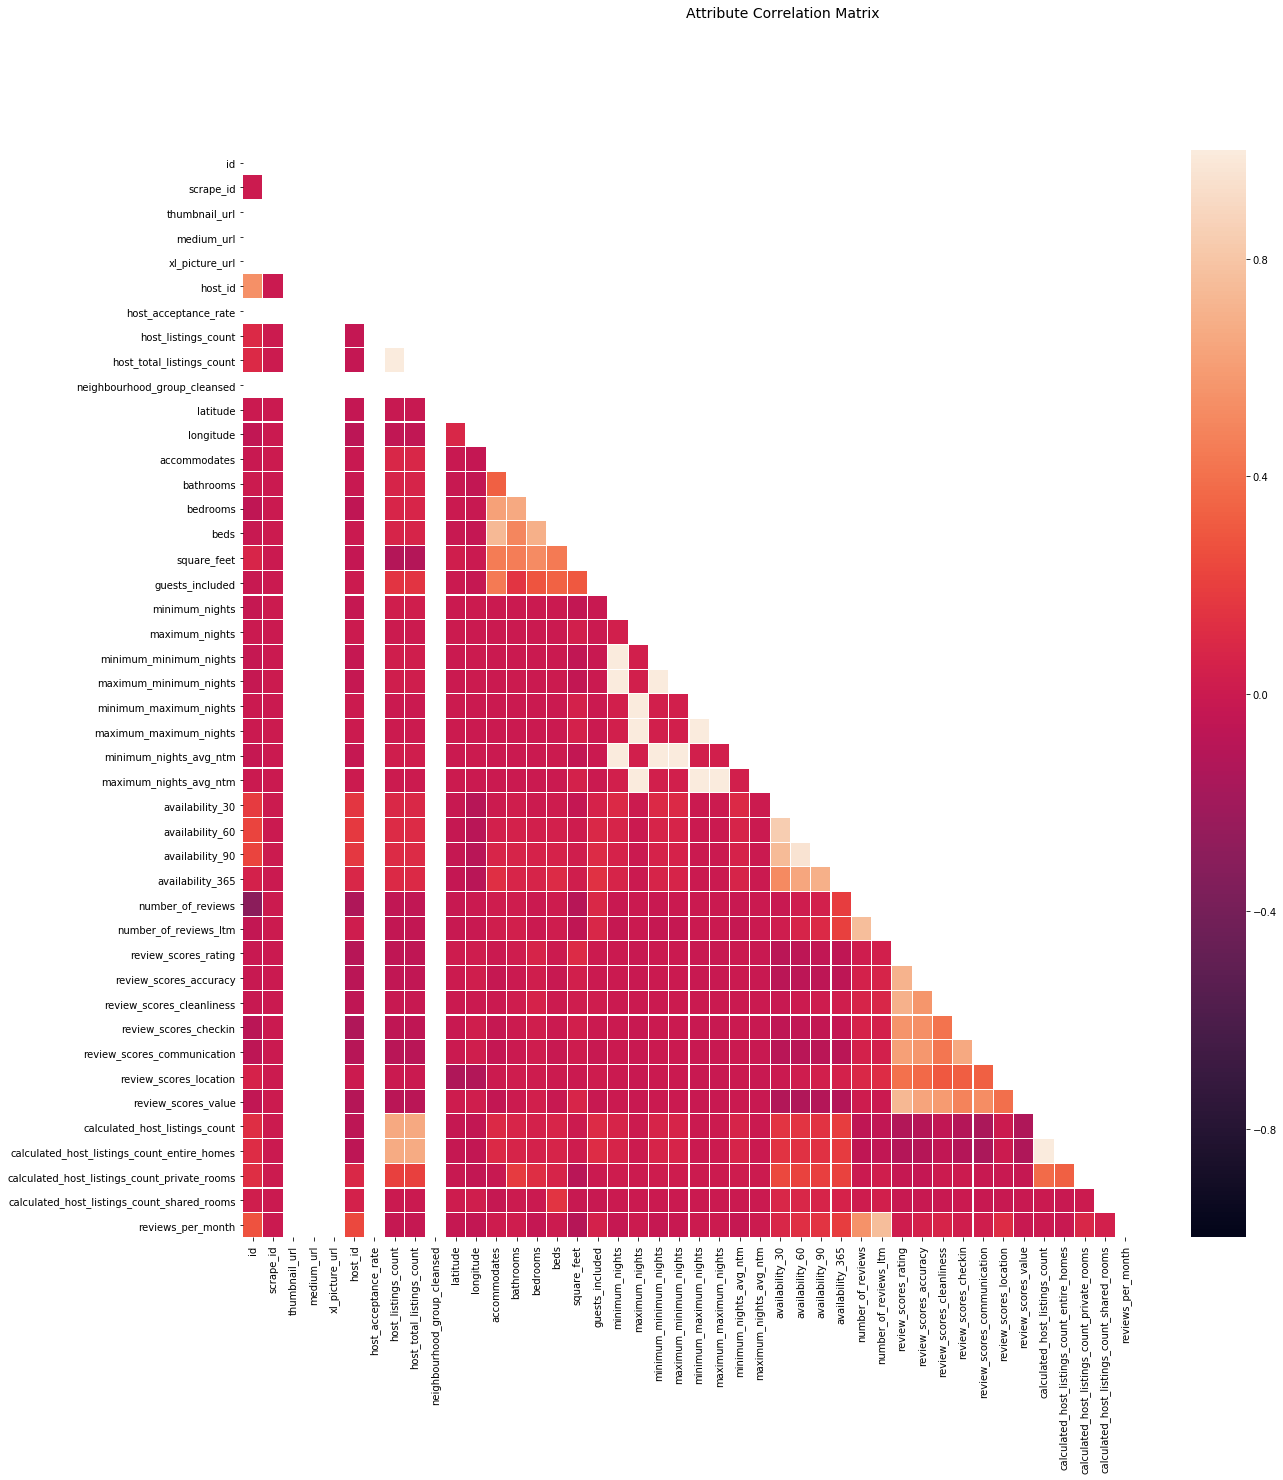

In [57]:
# calculate correlation
corr = df_paris.corr()

# plot correlation matrix
fig = plt.figure(figsize=(20, 20))
mask = np.zeros_like(corr, dtype=np.bool) # create mask to cover the upper triangle
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(corr, annot=False, mask=mask, vmin=-1, vmax=1,linewidths=0.1)
fig.suptitle('Attribute Correlation Matrix', fontsize=14)

The light shade between bed, bedroom and accommodates confirms that they are highly correlated. Given this, we will only use one of them. Whilst any would work, we will use bedroom, as this is generally understood to be the best determinant of price.

Thus, we will compare house prices between London and Paris based on combinations from:
1. room_type
2. bedrooms

Furthermore, given that bedrooms range from 0 to 22 in London and 0 to 50 in Paris (based on description matrix above), we need to bucket this to have a meaningful comparison.

/Users/jeffreylee/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jeffreylee/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


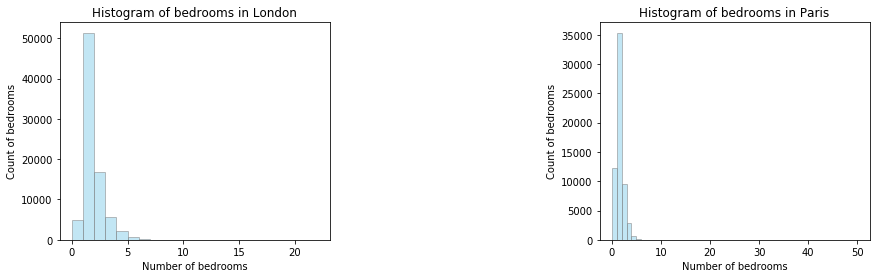

In [58]:
fig = plt.figure()
fig.subplots_adjust(hspace=1, wspace=1, right=2) # set parameters to adjust plot positioning
fig.add_subplot(1, 2, 1) # plot side by side

plt.hist(df_london['bedrooms'],
         color='skyblue',
         lw=1,
         ec='gray',
         alpha=0.5,
         bins=22); # increase bins, since default 10 is too little to see finer distribution
plt.title('Histogram of bedrooms in London')
plt.xlabel('Number of bedrooms')
plt.ylabel('Count of bedrooms');

fig.add_subplot(1, 2, 2)
plt.hist(df_paris['bedrooms'],
         color='skyblue',
         lw=1,
         ec='gray',
         alpha=0.5,
         bins=50);
plt.title('Histogram of bedrooms in Paris')
plt.xlabel('Number of bedrooms')
plt.ylabel('Count of bedrooms');

From the graphs, the number of listings drops to nearly 0 after 5. For this reason, we will group bedrooms >= 5 together into one category.

We will now group the listings together by *room_type* and *bedrooms*.

In [59]:
keep = ['room_type', 'bedrooms', 'price', 'id'] # just keep the columns we need

# Create London subsetted data
df_london_subset = df_london[keep]
df_london_subset.loc[df_london_subset['bedrooms'] > 5, 'bedrooms'] = 5.0 # group bedrooms > 5 together
df_london_subset.loc[:,'city'] = "London" # add city name to dataset
# convert price currency to float
df_london_subset['price'] = df_london_subset['price'].replace('[\$,]', '', regex=True).astype(float)

df_london_subset_g = df_london_subset.groupby(
    ['room_type', 'bedrooms'] # group by room_type and bedrooms
).agg(
    {
        'price':['mean'], # mean price
        'id':['count'] # count number of listings
    }
)
df_london_subset_g.columns = df_london_subset_g.columns.droplevel(1) # drop multi-level


# Create Paris subsetted data
df_paris_subset = df_paris[keep]
df_paris_subset.loc[df_paris_subset['bedrooms'] > 5, 'bedrooms'] = 5.0 # group bedrooms > 5 together
df_paris_subset.loc[:,'city'] = "Paris"
# convert price currency to float
df_paris_subset['price'] = df_paris_subset['price'].replace('[\$,]', '', regex=True).astype(float)

df_paris_subset_g = df_paris_subset.groupby(
    ['room_type', 'bedrooms'] # group by room_type and bedrooms
).agg(
    {
        'price':['mean'], # mean price
        'id':['count'] # count number of listings
    }
)
df_paris_subset_g.columns = df_paris_subset_g.columns.droplevel(1)  # drop multi-level


# Merge the two data sets together
df_london_paris = pd.merge(df_london_subset_g, df_paris_subset_g,
                                     how='left', on=['room_type','bedrooms'])
# rename columns
df_london_paris.rename(index=str,
                       columns={"price_x": "london_price",
                                "price_y": "paris_price",
                                "id_x": "london_listing_count",
                                "id_y": "paris_listing_count"
                               },
                      inplace=True);
# Determine cost of london compared to paris
df_london_paris.loc[:,'london_paris_cmp'] = (df_london_paris['london_price']/df_london_paris['paris_price'])-1

display(df_london_paris)

/Users/jeffreylee/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/jeffreylee/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jeffreylee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

london_price  london_listing_count  paris_price  \
room_type       bedrooms                                                    
Entire home/apt 0.0         107.184489                  3881    72.031882   
                1.0         116.810888                 17799    96.231795   
                2.0         172.417385                 15899   165.813926   
                3.0         243.577289                  5363   273.202372   
                4.0         313.585728                  2088   399.548780   
                5.0         485.957471                   870   655.232704   
Private room    0.0          63.416824                  1058   105.291971   
                1.0          56.838539                 32819   110.666246   
                2.0          81.526923                  1040   213.854305   
                3.0         124.887160                   257   301.956522   
                4.0         107.581633                    98   259.600000   
                5.0         161.903846                    52   272.777778   
Shared room     0.0          77.000000                     1          NaN   
                1.0          81.736292                   766    49.439655   

                          paris_listing_count  london_paris_cmp  
room_type       bedrooms                                         
Entire home/apt 0.0                   12013.0          0.488015  
                1.0                   27753.0          0.213849  
                2.0                    9163.0          0.039825  
                3.0                    2782.0         -0.108436  
                4.0                     656.0         -0.215150  
                5.0                     159.0         -0.258344  
Private room    0.0                     274.0         -0.397705  
                1.0                    7137.0         -0.486397  
                2.0                     302.0         -0.618774  
                3.0                      46.0         -0.586407  
                4.0                       5.0         -0.585587  
                5.0                      18.0         -0.406462  
Shared room     0.0                       NaN               NaN  
                1.0                     464.0          0.653254

In [60]:
# write to csv
df_london_paris = df_london_paris.reset_index() # reset index before exporting
df_london_paris.to_csv('/Users/jeffreylee/Documents/file3.csv',
                                 index = None, header=True)

<img src="images/3.1 London & Paris price comparison (entire home).png">

<img src="images/3.1 London & Paris price comparison (private).png">

<img src="images/3.1 London & Paris price comparison (shared).png">

We now have a very clear picture of price comparison between London and Paris. Key findings are:
- For entire home/apt, London is significantly more expensive than Paris when number of bedrooms are 2 or fewer. However more than 2, Paris becomes noticeably more expensive. It is important to note however in both cities, the majority of listings are for 2 or fewer bedrooms, thus overall, London will still be more expensive.
- For Private rooms, Paris is always more expensive
- For Share rooms, London is always more expensive

There is an interesting finding here. We can see that Paris seems to be cheaper for typical accommodation, however for more luxurious accommodation (private rooms, large property etc.), Paris becomes more expensive. This perhaps highlights difference in preference and value attributed luxury products. It would be interesting to conduct further analysis into spending behaviour to support this hypothesis!

The initial hypothesis that London is 20% more expensive than Paris may have some truth, however we are unable to compare overall living costs. Using accommodation price as a proxy, we see that whilst on average London may be more expensive, diving deeper this also depends on the type of accommodation.